In [4]:
# Crafted by Collin Miller

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [6]:
import bisect
import cv2
import h5py
import keras
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import sys
import time

import ChopinNet
import BachNet
from heapq import heappop as pop
from heapq import heappush as push
from sklearn import feature_extraction
from utils import graph_utils
from utils import display_utils
from utils import preprocessing_utils

Using TensorFlow backend.


In [8]:
%matplotlib inline

In [5]:
receptive_field_shape = (15, 15)

In [6]:
img, gt, seeds = preprocessing_utils.load_image("data/train/chopin/original",
                                                "data/train/input/slice_0",
                                                "data/train/input/slice_0_gt")

data/train/input/slice_0_gt data/train/chopin/original


In [7]:
img, gt, seeds = preprocessing_utils.load_image("data/train/chopin/seyed",
                                                "data/train/input/image_segprob.0411.trimmed",
                                                "data/train/input/merged_segprob.0411.trimmed")

data/train/input/merged_segprob.0411.trimmed data/train/chopin/seyed


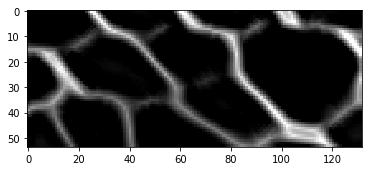

In [8]:
plt.imshow(img, cmap='gray')

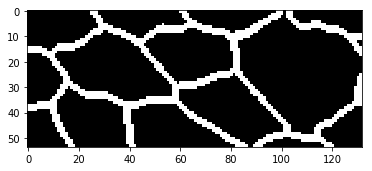

In [9]:
plt.imshow(gt, cmap='gray')

In [10]:
seeds

[(43, 25),
 (46, 56),
 (46, 125),
 (46, 5),
 (52, 103),
 (26, 64),
 (6, 11),
 (3, 44),
 (2, 79),
 (23, 107),
 (2, 120),
 (16, 64),
 (22, 33),
 (12, 130),
 (26, 5)]

In [11]:
bach = BachNet.BachNet()
bach.build(receptive_field_shape, 1)
bach.load_model("models/saved_model/Bach/model.h5")

In [12]:
bps = bach.boundary_probabilities(img)

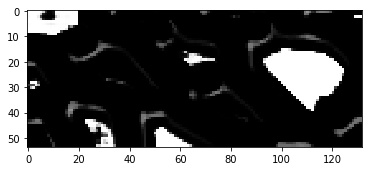

In [13]:
plt.imshow(bps, cmap='gray')

In [14]:
graph = graph_utils.prims_initialize(img)

In [16]:
chopin = ChopinNet.Chopin()
chopin.build(receptive_field_shape)
chopin.initialize_session()

In [17]:
I_a = np.stack((img, bps), axis=-1)

In [18]:
img.shape

(54, 132)

In [19]:
I_a.shape

(54, 132, 2)

In [20]:
ground_truth_cuts, gt_graph, gt_assignments = graph_utils.generate_gt_cuts(gt, seeds, assignments=True)

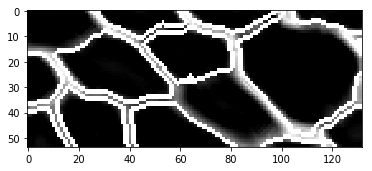

In [24]:
plt.imshow(display_utils.view_boundaries(img, ground_truth_cuts))

In [25]:
loss_timeline = []

In [26]:
for x in range(1):
    start = time.time()
    msf = chopin.predicted_msf(I_a, graph, seeds)
    segmentations = display_utils.assignments(np.zeros_like(img), msf, seeds)

    shortest_paths = nx.get_node_attributes(msf, 'path')
    assignments = nx.get_node_attributes(msf, 'seed')
    cuts = graph_utils.get_cut_edges(msf)
    
    #acc = utils.accuracy(assignments, gt_assignments)
    #print("Accuracy: ", acc)
    #acc_timeline.append(acc)

    #filename = "epoch_{}.png".format(epoch)

    #mask = utils.transparent_mask(img, segmentations)

    #plt.imsave(os.path.join(foldername, filename), mask)

    constrained_msf = msf.copy()

    constrained_msf.remove_edges_from(ground_truth_cuts)

    constrained_msf = graph_utils.minimum_spanning_forest(constrained_msf, seeds)

    ground_truth_paths = nx.get_node_attributes(constrained_msf, 'path')

    children = graph_utils.compute_root_error_edge_children(shortest_paths,
                                                      ground_truth_paths, cuts,
                                                      ground_truth_cuts)

    weights = []
    static_images = []
    dynamic_images = []

    for (u, v), weight in children.iteritems():

        try:
            static_images.append(msf.get_edge_data(u, v)['static_image'])
            dynamic_images.append(msf.get_edge_data(u, v)['dynamic_image'])
            weights.append(weight)
            altitude_val = msf.get_edge_data(u, v)['weight']
        except KeyError:
            pass

    batches = zip(preprocessing_utils.create_batches(np.expand_dims(np.stack(weights), 1)),
                  preprocessing_utils.create_batches(np.stack(static_images)),
                  preprocessing_utils.create_batches(np.stack(dynamic_images)))

    loss = 0
    with chopin.sess.as_default():
        chopin.sess.run(chopin.zero_ops)

        for w, s, d in batches:
            feed_dict = {chopin.gradient_weights: w.transpose(),
                         chopin.static_input: s,
                         chopin.dynamic_input: d,
                         keras.backend.learning_phase(): 0}

            chopin.sess.run(chopin.accum_ops, feed_dict)
            loss = chopin.sess.run(chopin.loss, feed_dict)
            loss += loss[0][0]

        chopin.sess.run(chopin.train_step)
    
    print(time.time() - start)

    f_name = "Epoch_{}".format(x)
    plt.imsave(f_name, segmentations)
    loss_timeline.append(loss)
    print("Loss: ", loss)

Starting gradient segmentation...
Segmentation done: 308.327285s
-2 -0.0633571
3 -0.00356686
-4 0.041213
-15 -0.187378
-21 -0.125337
1 -0.361125
-1 0.20386
-11 0.0598275
-86 -0.202524
4 -0.30129
1 -0.14996
20 -0.135189
-1 0.281345
2 -0.1492
1 -0.0834769
-12 0.000996798
2 -0.127935
1 0.0546055
-2 0.0919062
2 -0.212962
1587 -0.0101202
1 -0.28729
-33 -0.394072
163 -0.0721685
-2 0.110844
-3 0.0112514
-12 -0.31219
-1 -0.269561
-1 0.25545
4 -0.229161
-1 0.203457
-3 0.125177
1 -0.0394186
3 -0.1372
-2 -0.217095
-1217 -0.0278491
-1 0.145037
-20 -0.156175
-1 0.0450719
9 -0.149029
1 -0.0902798
1 -0.119908
-1713 -0.16691
-1466 -0.418649
1 -0.0988988
1 -0.0843706
353 -0.0362617
1 -0.094892
-141 -0.186711
498 -0.0150772
-9 0.17808
6 -0.202563
4 -0.123571
-7 0.123522
-9 0.0244184
-842 -0.202263
1109.50583485
325.797301054
Loss:  [[ 2201.0078125]]
Starting gradient segmentation...
Segmentation done: 303.844686s
1 38.7364
-6 43.0653
-1 47.3277
-1 30.8021
-2 74.2975
-13 40.8088
-6 42.5359
-1 111.774
-5 

324.413881063
Loss:  [[-117206.0234375]]
Starting gradient segmentation...
Segmentation done: 308.492853s
2 1298.83
-2 1071.34
-5 1610.92
1 924.762
-3 1675.12
5 1246.41
3 129.401
-1 1563.22
-1 1319.88
-4 1091.6
-37 1530.92
-187 743.535
-3 1063.85
-5 861.603
-7 1157.73
-2 1395.43
-3 1166.29
-1 1624.07
1 1615.79
-4 1783.43
156 907.981
-1 1509.56
-1 1178.61
-13 779.653
-1 1205.8
27 1107.63
6 115.323
1 866.199
-1 1032.46
2 2104.55
-2 677.89
-1 1221.78
-3 1405.92
-3 577.176
-31 1375.69
-1 1321.63
14 1454.86
-2 888.299
-4 1340.27
-3 1251.31
-1 1434.35
12 1853.15
3 918.14
-1 1629.41
-8 924.456
-3 900.661
32 130.177
1 823.898
36 116.997
-28 1168.35
-2 1156.57
-2 1126.81
-19 1071.91
-3 1091.11
-4 599.008
-70 579.357
-1 1294.53
-2 625.176
1 1758.45
18 1044.39
-9 1125.75
-2 1322.74
-4 1150.18
-50 1319.71
13 1041.5
-793 558.352
-2 1448.02
13 248.7
-1 1695.87
-2 1060.33
-88 1095.29
-1 1849.13
1 1444.1
-1 1527.94
1 1734.13
3 1709.44
-12 737.904
-1 1333.16
-2 1076.93
1 1191.77
-2 1247.78
-3 531.749
-

320.779417038
Loss:  [[-329111.59375]]
Starting gradient segmentation...
Segmentation done: 285.673872s
-1 724.557
-1 955.649
-7 975.44
-8 209.18
-43 663.869
-1 423.96
3 672.833
-2 771.77
35 363.055
1 777.578
-4 887.685
-5 539.37
-3 818.457
-3 832.146
-3 737.403
-8 626.972
-3 775.192
-6 777.77
-2 669.973
4 880.202
3 371.34
55 677.671
5 688.388
8 426.274
1 1154.02
59 853.32
176 705.76
1 1157.83
2 811.511
-1 540.154
-1 995.82
-3 795.659
18 548.737
1 1056.17
-1 386.452
-4 977.311
-9 668.121
28 428.299
-3 778.107
-1 736.127
2 270.232
-1 1030.47
-8 705.739
-1 1163.68
-7 1193.68
1 558.025
-13 415.498
-3 1034.02
-2 614.922
-2 744.595
-1 634.852
-1 644.5
1 1338.75
-1 728.985
-6 754.03
-4 573.042
-1 814.567
-2 765.376
-33 423.017
-4 666.64
-2 629.374
-4 851.025
1 995.288
-3 971.278
-2 788.776
-9 501.046
-30 930.972
-2 796.111
13 814.955
4 655.265
-15 430.315
-65 521.461
-2 674.455
-863 372.37
9 913.105
-3 872.349
-6 684.879
5 1091.56
-30 486.134
-2 351.421
-2 890.801
-5 578.804
-7 967.172
-58 7

329.092275858
Loss:  [[-6293.9296875]]
Starting gradient segmentation...
Segmentation done: 312.269217s
1 672.136
-1 614.998
12 233.434
9 667.78
-242 639.27
-3 606.095
33 610.652
30 637.749
10 645.124
1 609.208
-4 571.173
57 575.601
-5 688.917
-151 620.512
-8 645.339
64 632.654
-7 646.425
9 523.428
4 677.805
-1 624.741
17 641.891
13 663.715
10 661.339
-1 757.914
-83 599.276
-1 611.326
2 609.752
5 498.945
-1 648.307
4 731.567
-634 547.364
3 550.569
3 626.714
2 628.727
-2 609.398
12 620.523
-2 666.184
-93 637.782
-1 644.94
-2 713.057
-3 638.141
33 583.104
2 628.699
8 620.923
-11 697.052
-7 601.256
1 603.124
18 614.176
31 623.764
39 688.326
-4 656.224
16 227.116
-86 563.674
54 668.805
35 645.385
-65 610.396
7 716.969
1 607.901
9 636.174
2 636.861
21 504.444
17 611.093
17 617.482
3 238.978
29 605.189
-358 602.096
2 629.906
7 644.662
-231 600.748
17 614.958
-77 591.32
5 593.597
-1 609.83
1 613.701
1780 609.53
1 572.002
9 222.759
11 606.956
34 604.574
-1 612.874
26 635.482
67 587.402
2 583.8

336.846523046
Loss:  [[ 1368675.5]]
Starting gradient segmentation...
Segmentation done: 304.692585s
1 308.511
-69 503.944
-2 505.874
-1 625.86
-12 589.102
2 605.322
-3 519.859
-275 566.269
2 587.18
1525 603.821
-3 710.827
3 681.796
-8 547.217
12 595.03
-2 603.356
1 576.455
2 92.1954
-2 629.998
-3 626.212
1 664.815
38 570.682
-9 517.299
-2 414.185
-2 637.485
-1 500.702
-21 577.702
-65 642.226
-2 492.958
2 222.337
2 597.433
-2 658.849
7 584.692
5 455.048
-3 456.62
23 602.529
-11 546.592
1 593.157
-1 628.472
-2 527.336
-1 648.838
21 552.298
-1 635.206
-6 515.384
1 691.29
-71 525.333
39 557.144
1 587.981
10 463.778
-4 576.489
-1 582.812
5 477.833
1 606.919
-1 473.319
-3 587.71
-55 590.468
-1 642.965
1 597.486
-193 584.33
30 646.637
-5 654.017
-4 626.923
2 317.128
2 275.18
6 500.289
-2 520.448
-5 485.316
8 392.619
-3 550.313
-6 533.557
1 583.704
5 650.057
-677 481.463
6 590.442
8 578.782
30 586.713
-5 486.852
-2 646.823
-3 456.222
4 532.591
-2 491.87
-1 644.176
-8 491.094
-1 579.881
-1 706

KeyboardInterrupt: 

In [ ]:
plt.plot(loss_timeline)

In [ ]:
404.079375982

In [1]:
img_path = "data/train/input/slice_0.png"
gt_path = "data/train/input/slice_0_gt.png"

In [2]:
import cv2

In [3]:
img = cv2.imread(img_path)
gt = cv2.imread(gt_path)

In [11]:
img = img[:50, :50]
gt = gt[:50, :50]

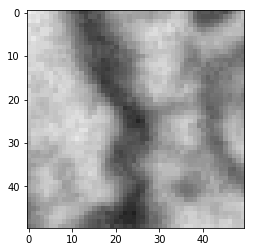

In [12]:
plt.imshow(img)

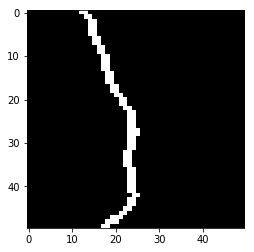

In [13]:
plt.imshow(gt)

In [14]:
plt.imsave(img_path, img)
plt.imsave(gt_path, gt)

# Modified

In [26]:
num_nodes = graph.number_of_nodes()
visited = np.zeros_like(img)
frontier = []

relative_assignments = RelativeAssignments(seeds,
                                           (I_a.shape[0],
                                            I_a.shape[1]),
                                           chopin.receptive_field_shape)
static_input_images = preprocessing_utils.prepare_input_images(I_a, height=23, width=23)

print("Starting gradient segmentation...")
start = time.time()

for u in seeds:

    # Assign seed to chopin.
    graph.node[u]['seed'] = u

    relative_assignments.assign_node(u, seeds.index(u))

    visited[u[0], u[1]] = 1

    # Store path.
    graph.node[u]['path'] = [u]

    # Push all edges
    static_input = []
    dynamic_input = []
    edges = []
    for u, v in graph.edges(u):
        edges.append((u, v))
        seed_index = seeds.index(graph.node[u]['seed'])
        dynamic_input.append(relative_assignments.prepare_images([(u, seed_index)])[0])
        static_input.append(static_input_images[v[0] * I_a.shape[1] + v[1]])
        
    static_input = np.stack(static_input)
    dynamic_input = np.stack(dynamic_input)
    
    altitude_values = chopin.predict_altitudes(static_input,
                                              dynamic_input)
    
    for (u, v), alt in zip(edges, altitude_values):
        graph.edge[u][v]['weight'] = alt[0]
        push(frontier, (alt, u, v))

while frontier:
    W, u, v = pop(frontier)
    

    if visited[v[0], v[1]] == 1:
        continue

    # Assign the node
    graph.node[v]['seed'] = graph.node[u]['seed']

    relative_assignments.assign_node(v,
                                     seeds.index(graph.node[u]['seed']))

    # Store path.
    graph.node[v]['path'] = graph.node[u]['path'] + [v]

    visited[v[0], v[1]] = 1

    
    static_input = []
    dynamic_input = []
    edges = []
    for v, w in graph.edges(v):
        if visited[w[0], w[1]] == 0:
            edges.append((v, w))
            seed_index = seeds.index(graph.node[v]['seed'])
            dynamic_input.append(relative_assignments.prepare_images([(v, seed_index)])[0])
            static_input.append(static_input_images[w[0] * I_a.shape[1] + w[1]])
            
    try:
        static_input = np.stack(static_input)
        dynamic_input = np.stack(dynamic_input)

        altitude_values = chopin.predict_altitudes(static_input,
                                                  dynamic_input)

        for (v, w), alt in zip(edges, altitude_values):
            graph.edge[v][w]['weight'] = alt[0]
            push(frontier, (alt, v, w))
    except ValueError:
        pass
            
end = time.time()
print("Segmentation done: %fs" % (end - start))

Starting gradient segmentation...


KeyboardInterrupt: 

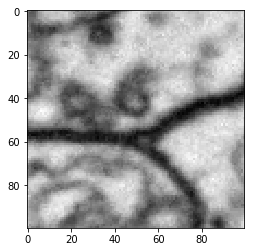

In [46]:
plt.imshow(img, cmap='gray')

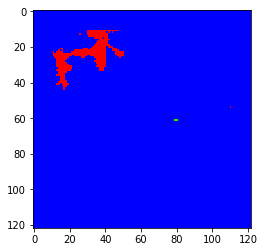

In [63]:
plt.imshow(relative_assignments._p_rel_assign[2])

# Original

In [165]:
class RelativeAssignments:
    def __init__(self, seeds, image_size, receptive_field_shape):
        self.receptive_field_shape = receptive_field_shape
        self.seeds = seeds
        self.image_size = image_size
        self._rgb = np.zeros((len(seeds), image_size[0], image_size[1], 3))
        self._rgb[:, :, :] = [0, 0, 1]

        npad = ((0, 0), (receptive_field_shape[0] // 2, receptive_field_shape[1] // 2),
                (receptive_field_shape[0] // 2, receptive_field_shape[1] // 2), (0, 0))

        self._padded_rgb = np.pad(self._rgb, npad, 'edge')

    def assign_node(self, node, seed_index):
        x = node[0] + self.receptive_field_shape[0] // 2
        y = node[1] + self.receptive_field_shape[1] // 2

        self._padded_rgb[:seed_index, x, y] = [1, 0, 0]
        self._padded_rgb[seed_index, x, y] = [0, 1, 0]
        self._padded_rgb[seed_index + 1:, x, y] = [1, 0, 0]

        return

    def get_node_image(self, node, seed):
        seed_index = self.seeds.index(seed)

        return preprocessing_utils.crop_2d(self._padded_rgb[seed_index], node,
                             self.receptive_field_shape[0],
                             self.receptive_field_shape[1])

In [166]:
num_nodes = graph.number_of_nodes()
visited = np.zeros_like(img)
frontier = []

relative_assignments = RelativeAssignments(seeds,
                                           (I_a.shape[0],
                                            I_a.shape[1]),
                                           chopin.receptive_field_shape)

print("Starting gradient segmentation...")
start = time.time()

for u in seeds:

    # Assign seed to chopin.
    graph.node[u]['seed'] = u

    relative_assignments.assign_node(u, seeds.index(u))

    visited[u[0], u[1]] = 1

    # Store path.
    graph.node[u]['path'] = [u]

    # Push all edges
    for u, v in graph.edges(u):

        seed = graph.node[u]['seed']

        cropped_rgb = relative_assignments.get_node_image(v,
                                                          seed)

        cropped_rgb = np.expand_dims(cropped_rgb, 0)

        cropped_image = preprocessing_utils.crop_2d(I_a,
                                      v,
                                      chopin.receptive_field_shape[0],
                                      chopin.receptive_field_shape[1])

        cropped_image = np.expand_dims(cropped_image, 0)

        altitude_value = chopin.predict_altitudes(cropped_image,
                                                  cropped_rgb)

        graph.edge[u][v]['weight'] = altitude_value[0][0]
        try:
            graph.edge[u][v]['static_image'] = cropped_image
            graph.edge[u][v]['dynamic_image'] = cropped_rgb
        except KeyError:
            pass

        del cropped_image, cropped_rgb

        push(frontier, (graph[u][v].get('weight', 1), u, v))

while frontier:
    W, u, v = pop(frontier)

    if visited[v[0], v[1]] == 1:
        continue

    # Assign the node
    graph.node[v]['seed'] = graph.node[u]['seed']

    relative_assignments.assign_node(v,
                                     seeds.index(graph.node[u]['seed']))

    # Store path.
    graph.node[v]['path'] = graph.node[u]['path'] + [v]

    visited[v[0], v[1]] = 1

    for v, w in graph.edges(v):
        if not w in visited:

            seed = graph.node[v]['seed']

            cropped_rgb = relative_assignments.get_node_image(w, seed)

            cropped_rgb = np.expand_dims(cropped_rgb, 0)

            cropped_image = preprocessing_utils.crop_2d(I_a,
                                          w,
                                          chopin.receptive_field_shape[0],
                                          chopin.receptive_field_shape[1])

            cropped_image = np.expand_dims(cropped_image, 0)

            altitude_value = chopin.predict_altitudes(cropped_image,
                                                      cropped_rgb)

            graph.edge[v][w]['weight'] = altitude_value[0][0]

            try:
                graph.edge[v][w]['static_image'] = cropped_image
                graph.edge[v][w]['dynamic_image'] = cropped_rgb
            except KeyError:
                pass

            push(frontier, (graph[v][w].get('weight', 1), v, w))

end = time.time()
print("Segmentation done: %fs" % (end - start))


Starting gradient segmentation...


ValueError: Cannot feed value of shape (1, 7, 15, 2) for Tensor u'Placeholder:0', which has shape '(?, 23, 23, 2)'

In [147]:
seeds

[(5, 5), (90, 90)]

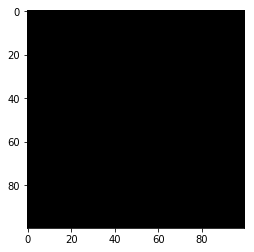

In [149]:
plt.imshow(display_utils.assignments(img, graph, seeds))

In [ ]:
num_nodes = graph.number_of_nodes()
visited = []
frontier = []

push = heappush
pop = heappop

relative_assignments = RelativeAssignments(seeds,
                                           (I_a.shape[0],
                                            I_a.shape[1]),
                                           chopin.receptive_field_shape)

print("Starting gradient segmentation...")
start = time.time()

while len(visited) < num_nodes:

    for u in seeds:

        # Assign seed to chopin.
        graph.node[u]['seed'] = u

        relative_assignments.assign_node(u, seeds.index(u))

        visited.append(u)

        # Store path.
        graph.node[u]['path'] = [u]

        # Push all edges
        for u, v in graph.edges(u):

            seed = graph.node[u]['seed']

            cropped_rgb = relative_assignments.get_node_image(v,
                                                              seed)

            cropped_rgb = np.expand_dims(cropped_rgb, 0)

            cropped_image = preprocessing_utils.crop_2d(I_a,
                                          v,
                                          chopin.receptive_field_shape[0],
                                          chopin.receptive_field_shape[1])

            cropped_image = np.expand_dims(cropped_image, 0)

            altitude_value = chopin.predict_altitudes(cropped_image,
                                                      cropped_rgb)

            graph.edge[u][v]['weight'] = altitude_value[0][0]
            try:
                graph.edge[u][v]['static_image'] = cropped_image
                graph.edge[u][v]['dynamic_image'] = cropped_rgb
            except KeyError:
                pass

            del cropped_image, cropped_rgb

            push(frontier, (graph[u][v].get('weight', 1), u, v))

    while frontier:
        W, u, v = pop(frontier)

        if v in visited:
            continue

        # Assign the node
        graph.node[v]['seed'] = graph.node[u]['seed']

        relative_assignments.assign_node(v,
                                         seeds.index(graph.node[u]['seed']))

        # Store path.
        graph.node[v]['path'] = graph.node[u]['path'] + [v]

        visited.append(v)

        for v, w in graph.edges(v):
            if not w in visited:

                seed = graph.node[v]['seed']

                cropped_rgb = relative_assignments.get_node_image(w, seed)

                cropped_rgb = np.expand_dims(cropped_rgb, 0)

                cropped_image = preprocessing_utils.crop_2d(I_a,
                                              w,
                                              chopin.receptive_field_shape[0],
                                              chopin.receptive_field_shape[1])

                cropped_image = np.expand_dims(cropped_image, 0)

                altitude_value = chopin.predict_altitudes(cropped_image,
                                                          cropped_rgb)

                graph.edge[v][w]['weight'] = altitude_value[0][0]

                try:
                    graph.edge[v][w]['static_image'] = cropped_image
                    graph.edge[v][w]['dynamic_image'] = cropped_rgb
                except KeyError:
                    pass

                push(frontier, (graph[v][w].get('weight', 1), v, w))

    end = time.time()
    print("Segmentation done: %fs" % (end - start))


In [160]:
def img_to_graph(image):
    """Converts an image to a graph.
    
    This function takes in an image and returns a 
    4-connected grid graph.  The nodes of this graph
    are labeled as such: every pixel is a node, 
    the label of each node is the corresponding 
    (x, y) coordinates.
    
    Args:
        image (numpy_array): The input image.
        
    Returns:
        A network X graph.
    
    """

    image = image.astype(np.int16)

    coo_matrix = feature_extraction.img_to_graph(image)
    graph = nx.from_scipy_sparse_matrix(coo_matrix)

    node_labels = graph.nodes()
    node_labels = np.array(node_labels)
    node_labels = node_labels.reshape(image.shape)
    graph.remove_edges_from(graph.selfloop_edges())

    return graph

In [155]:
seeds = [(5, 5), (90, 90)]

In [168]:
seeds = [50, 1, 15]

In [169]:
graph = img_to_graph(img)

In [162]:


print("Starting gradient segmentation...")
start = time.time()

num_nodes = graph.number_of_nodes()
visited = np.zeros((graph.number_of_nodes()))
frontier = []

for u in seeds:

    # Assign seed to self.
    graph.node[u]['seed'] = u

    visited[u] = 1

    # Store path.
    graph.node[u]['path'] = [u]

    # Push all edges
    for u, v in graph.edges(u):
        try:
            graph.edge[u][v]['image'] = graph.node[v]['image']
        except KeyError:
            pass

        push(frontier, (graph[u][v].get('weight', 1), u, v))
        
while frontier:
        W, u, v = pop(frontier)

        if visited[v] == 1:
            continue

        # Assign the node
        graph.node[v]['seed'] = graph.node[u]['seed']

        # Store path.
        graph.node[v]['path'] = graph.node[u]['path'] + [v]

        visited[v] = 1

        for v, w in graph.edges(v):
            if not w in visited:
                try:
                    graph.edge[v][w]['image'] = graph.node[w]['image']
                except KeyError:
                    pass
                push(frontier, (graph[v][w].get('weight', 1), v, w))


end = time.time()
print("Segmentation done: %fs" % (end - start))

Starting gradient segmentation...
Segmentation done: 1.841834s


In [165]:
node_labels = graph.nodes()
node_labels = np.array(node_labels)
node_labels = node_labels.reshape(img.shape)

mapping = {}
for index, x in np.ndenumerate(node_labels):
    mapping[x] = index

graph = nx.relabel_nodes(graph, mapping)

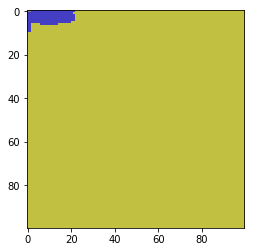

In [166]:
plt.imshow(display_utils.assignments(img, graph, seeds))

In [74]:
num_nodes = graph.number_of_nodes()
visited = []
frontier = []
       
print("Starting gradient segmentation...")
start = time.time()

while len(visited) < num_nodes:

    for u in seeds:

        # Assign seed to self.
        graph.node[u]['seed'] = u

        visited.append(u)

        # Store path.
        graph.node[u]['path'] = [u]

        # Push all edges
        for u, v in graph.edges(u):
            try:
                graph.edge[u][v]['image'] = graph.node[v]['image']
            except KeyError:
                pass

            push(frontier, (graph[u][v].get('weight', 1), u, v))

    while frontier:
        W, u, v = pop(frontier)

        if v in visited:
            continue

        # Assign the node
        graph.node[v]['seed'] = graph.node[u]['seed']

        # Store path.
        graph.node[v]['path'] = graph.node[u]['path'] + [v]

        visited.append(v)

        for v, w in graph.edges(v):
            if not w in visited:
                try:
                    graph.edge[v][w]['image'] = graph.node[w]['image']
                except KeyError:
                    pass
                push(frontier, (graph[v][w].get('weight', 1), v, w))

end = time.time()
print("Segmentation done: %fs" % (end - start))

Starting gradient segmentation...
Segmentation done: 9.871998s


In [80]:
graph.number_of_nodes()

10000

In [84]:
visited[0]

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [65]:
val = bisect.bisect(visited, 3245)

In [66]:
val == 3245

False

In [57]:
visited

[1, 15, 50]

In [12]:
def minimum_spanning_forest(graph, seeds, timed=False):
    """Computes the minimum spanning forest for an image.
    
    This function computes the minimum spanning forest 
    for an image.  The weights for the graph are the 
    pixel gradients of the image.  Starting from the
    given seeds, each region is grown until the entire
    image is segmented.
    
    Args:
        graph (nx_graph): A networkx graph that has 
        been initialized.
        seeds (list): A list of (x, y) tuples to start 
        region growing.  
        timed (boolean): A flag that if True, will display
        how long it took to run the minimum spanning forest.
        
    Returns:
        A networkx graph with every node assigned to a 
        seed and the path from each seed to their respective 
        node.
    
    """
    
    
    num_nodes = graph.number_of_nodes()
    visited = []
    frontier = []

    push = heappush
    pop = heappop

    if timed:         
        print("Starting gradient segmentation...")
        start = time.time()

    while len(visited) < num_nodes:

        for u in seeds:

            # Assign seed to self.
            graph.node[u]['seed'] = u

            visited.append(u)

            # Store path.
            graph.node[u]['path'] = [u]

            # Push all edges
            for u, v in graph.edges(u):
                try:
                    graph.edge[u][v]['image'] = graph.node[v]['image']
                except KeyError:
                    pass

                push(frontier, (graph[u][v].get('weight', 1), u, v))

        while frontier:
            W, u, v = pop(frontier)

            if v in visited:
                continue

            # Assign the node
            graph.node[v]['seed'] = graph.node[u]['seed']

            # Store path.
            graph.node[v]['path'] = graph.node[u]['path'] + [v]

            visited.append(v)

            for v, w in graph.edges(v):
                if not w in visited:
                    try:
                        graph.edge[v][w]['image'] = graph.node[w]['image']
                    except KeyError:
                        pass
                    push(frontier, (graph[v][w].get('weight', 1), v, w))

    if timed:
        end = time.time()
        print("Segmentation done: %fs" % (end - start))

    return graph

In [43]:
def get_cremi_data():
    
    # Get neuron ids from Cremi data.
    with h5py.File("sample_A_20160501.hdf", "r") as hdf:
        print ("Initializing...")
        labels = hdf['volumes']['labels']['neuron_ids'][:]
        raw = hdf['volumes']['raw'].value
        print ("Done!")
        
    return raw, labels

Initializing...
Done!


In [ ]:
def random_sample():
    

In [46]:
labels

array([[[   885,   2064,   2064, ...,  24500,  24500,  24500],
        [  2064,   2064,   2064, ...,  24500,  24500,  24500],
        [  2064,   2064,   2064, ...,  24500,  24500,  24500],
        ..., 
        [  6036,   6036,   6036, ...,  19935,  19935,  19935],
        [  6036,   6036,   6036, ...,  19935,  19935,  19935],
        [  6036,   6036,   6036, ...,  19935,  19935,  19935]],

       [[   885,   2064,   2064, ...,  24500,  24500,  24500],
        [  2064,   2064,   2064, ...,  24500,  24500,  24500],
        [  2064,   2064,   2064, ...,  24500,  24500,  24500],
        ..., 
        [  6036,   6036,   6036, ...,  19935,  19935,  19935],
        [  6036,   6036,   6036, ...,  19935,  19935,  19935],
        [  6036,   6036,   6036, ...,  19935,  19935,  19935]],

       [[   885,   2064,   2064, ...,  24500,  24500,  24500],
        [  2064,   2064,   2064, ...,  24500,  24500,  24500],
        [  2064,   2064,   2064, ...,  24500,  24500,  24500],
        ..., 
        [

In [47]:
raw

array([[[118, 111, 103, ..., 151, 152, 149],
        [112, 102, 102, ..., 146, 150, 147],
        [110, 105, 105, ..., 147, 141, 135],
        ..., 
        [108, 106, 115, ..., 160, 158, 151],
        [113, 113, 125, ..., 158, 152, 148],
        [117, 121, 125, ..., 152, 146, 146]],

       [[134, 138, 131, ..., 127, 135, 145],
        [140, 142, 137, ..., 137, 141, 148],
        [143, 140, 136, ..., 144, 148, 155],
        ..., 
        [137, 146, 151, ..., 154, 160, 164],
        [147, 153, 156, ..., 152, 152, 153],
        [150, 155, 152, ..., 144, 141, 145]],

       [[ 93,  86,  82, ..., 158, 160, 158],
        [ 86,  82,  80, ..., 155, 158, 162],
        [ 71,  72,  68, ..., 156, 155, 159],
        ..., 
        [131, 150, 162, ..., 130, 130, 124],
        [132, 150, 156, ..., 126, 125, 124],
        [140, 148, 160, ..., 112, 114, 111]],

       ..., 
       [[124, 128, 124, ..., 109, 105, 109],
        [115, 118, 121, ..., 119, 125, 127],
        [109, 108, 110, ..., 132, 142, 

In [167]:
rel_assign = RelativeAssignments(seeds, img.shape, receptive_field_shape)

In [168]:
rel_assign.padded_ras.shape

(2, 122, 122, 3)

In [169]:
nodes = [(0, 0), (50, 50)]

In [204]:
rel_assign.prepare(nodes, seeds)

In [205]:
rel_assign.prepared_inputs

[((0, 0), 0), ((50, 50), 1)]

In [206]:
n, i = rel_assign.clip()

[((0, 0), 0), ((50, 50), 1)]


In [207]:
i.shape

(2, 23, 23, 3)

In [208]:
n

[(0, 0), (50, 50)]

In [209]:
rel_assign.clear()

In [52]:
start = time.time()
rel_assign.assign_node((0, 0), (1))
print(time.time() - start)

0.000195980072021


In [53]:
start = time.time()
rel_assign.assign_node((0, 5), (0))
print(time.time() - start)

0.000173091888428


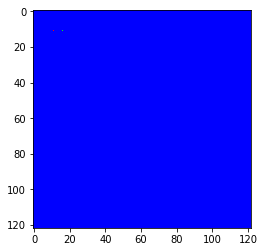

In [54]:
plt.imshow(rel_assign.padded_ras[0])

In [55]:
input_images = rel_assign.input_images([(0, 0), (0, 1)], [1, 0])

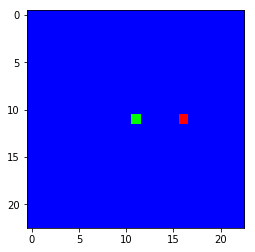

In [56]:
plt.imshow(input_images[0])

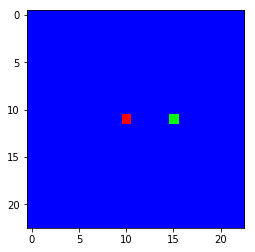

In [57]:
plt.imshow(input_images[1])

In [14]:
class RelativeAssignments:
    """Container for relative node assignments.
        
        Args:
            seeds: A `list` of seeds `tuples`.
            image_size: An image shape `tuple`.
            receptive_field_shape: The shape of the crops to be input to the network.   
            
        >>> seeds = [(0, 0), (50, 50)]
        >>> img = np.random.rand(100, 100)
        >>> rfs = (23, 23)
        >>> ra = Relative_assignments(seeds, img.shape, rfs)
        """
    def __init__(self, seeds, image_size, receptive_field_shape):
        self.receptive_field_shape = receptive_field_shape
        self.seeds = seeds
        self.image_size = image_size
        self._rel_assign = np.zeros((len(seeds), image_size[0], image_size[1], 3))
        self._rel_assign[:, :, :] = [0, 0, 1]

        npad = ((0, 0), (receptive_field_shape[0] // 2, receptive_field_shape[1] // 2),
                (receptive_field_shape[0] // 2, receptive_field_shape[1] // 2), (0, 0))

        self._p_rel_assign = np.pad(self._rel_assign, npad, 'edge')

    def assign_node(self, node, seed_index):
        x = node[0] + self.receptive_field_shape[0] // 2
        y = node[1] + self.receptive_field_shape[1] // 2

        self._p_rel_assign[:seed_index, x, y] = [1, 0, 0]
        self._p_rel_assign[seed_index, x, y] = [0, 1, 0]
        self._p_rel_assign[seed_index + 1:, x, y] = [1, 0, 0]

        return
    
    
    def prepare_images(self, prepared_input):
        """Returns the input images for the given nodes.
        
        Args:
            
            
        Returns:
            A `ndarray` of input images for the network.
        """
        
        images = []
        
        for node, seed_index in prepared_input:
            images.append(preprocessing_utils.crop_2d(self._p_rel_assign[seed_index], node,
                                        self.receptive_field_shape[0],
                                        self.receptive_field_shape[1]))
        return np.stack(images)
        
    @property
    def padded_ras(self):
        return self._p_rel_assign

In [20]:
def minimum_spanning_forest(img, graph, seeds, timed=False):
    """Computes the minimum spanning forest for an image.
    
    This function computes the minimum spanning forest 
    for an image.  The weights for the graph are the 
    pixel gradients of the image.  Starting from the
    given seeds, each region is grown until the entire
    image is segmented.
    
    Args:
        graph (nx_graph): A networkx graph that has 
        been initialized.
        seeds (list): A list of (x, y) tuples to start 
        region growing.  
        timed (boolean): A flag that if True, will display
        how long it took to run the minimum spanning forest.
        
    Returns:
        A networkx graph with every node assigned to a 
        seed and the path from each seed to their respective 
        node.
    
    """
    
    
    num_nodes = graph.number_of_nodes()
    visited = np.zeros(img.shape)
    frontier = []

    if timed:         
        print("Starting gradient segmentation...")
        start = time.time()

    for u in seeds:

        # Assign seed to self.
        graph.node[u]['seed'] = u

        visited[u[0], u[1]] = 1

        # Store path.
        graph.node[u]['path'] = [u]

        # Push all edges
        for u, v in graph.edges(u):
            push(frontier, (graph[u][v].get('weight', 1), u, v))

    while frontier:
        W, u, v = pop(frontier)

        if visited[v[0], v[1]] == 1:
            continue

        # Assign the node
        graph.node[v]['seed'] = graph.node[u]['seed']

        # Store path.
        graph.node[v]['path'] = graph.node[u]['path'] + [v]

        visited[v[0], v[1]] = 1

        for v, w in graph.edges(v):
            if visited[w[0], w[1]] == 0:
                push(frontier, (graph[v][w].get('weight', 1), v, w))

    if timed:
        end = time.time()
        print("Segmentation done: %fs" % (end - start))

    return graph

In [21]:
def generate_gt_cuts(gt_image, seeds, assignments=False):
    graph = graph_utils.prims_initialize(gt_image)

    for (x, y), d in np.ndenumerate(gt_image):
        graph.node[(x, y)]['altitude'] = d

    graph = minimum_spanning_forest(img, graph, seeds, timed=True)
    cuts = graph_utils.get_cut_edges(graph)

    if assignments:
        for (x, y), d in np.ndenumerate(gt_image):
            graph.node[(x, y)]['altitude'] = d

        gt_assignments = nx.get_node_attributes(graph, 'seed')

        return cuts, graph, gt_assignments
    else:
        return cuts

In [23]:
def predicted_msf(chopin, I_a, graph, seeds):
    num_nodes = graph.number_of_nodes()
    visited = np.zeros(I_a.shape[:-1])
    frontier = []

    relative_assignments = RelativeAssignments(seeds,
                                               (I_a.shape[0],
                                                I_a.shape[1]),
                                               chopin.receptive_field_shape)
    static_input_images = preprocessing_utils.prepare_input_images(I_a, height=receptive_field_shape[0],
                                                                   width=receptive_field_shape[1])

    print("Starting gradient segmentation...")
    start = time.time()

    for u in seeds:

        # Assign seed to chopin.
        graph.node[u]['seed'] = u

        relative_assignments.assign_node(u, seeds.index(u))

        visited[u[0], u[1]] = 1

        # Store path.
        graph.node[u]['path'] = [u]

        # Push all edges
        static_input = []
        dynamic_input = []
        edges = []
        for u, v in graph.edges(u):
            edges.append((u, v))
            seed_index = seeds.index(graph.node[u]['seed'])
            static_image = static_input_images[v[0] * I_a.shape[1] + v[1]]
            dynamic_image = relative_assignments.prepare_images([(u, seed_index)])[0]
            static_input.append(static_image)
            dynamic_input.append(dynamic_image)
            
            try:
                graph.edge[u][v]['static_image'] = static_image
                graph.edge[u][v]['dynamic_image'] = dynamic_image
            except KeyError:
                pass

        static_input = np.stack(static_input)
        dynamic_input = np.stack(dynamic_input)

        altitude_values = chopin.predict_altitudes(static_input,
                                                  dynamic_input)

        for (u, v), alt in zip(edges, altitude_values):
            graph.edge[u][v]['weight'] = alt[0]
            push(frontier, (alt, u, v))

    while frontier:
        W, u, v = pop(frontier)


        if visited[v[0], v[1]] == 1:
            continue

        # Assign the node
        graph.node[v]['seed'] = graph.node[u]['seed']

        relative_assignments.assign_node(v,
                                         seeds.index(graph.node[u]['seed']))

        # Store path.
        graph.node[v]['path'] = graph.node[u]['path'] + [v]

        visited[v[0], v[1]] = 1


        static_input = []
        dynamic_input = []
        edges = []
        for v, w in graph.edges(v):
            if visited[w[0], w[1]] == 0:
                edges.append((v, w))
                seed_index = seeds.index(graph.node[v]['seed'])
                static_image = static_input_images[w[0] * I_a.shape[1] + w[1]]
                dynamic_image = relative_assignments.prepare_images([(v, seed_index)])[0]
                static_input.append(static_image)
                dynamic_input.append(dynamic_image)

                try:
                    graph.edge[u][v]['static_image'] = static_image
                    graph.edge[u][v]['dynamic_image'] = dynamic_image
                except KeyError:
                    pass

        try:
            static_input = np.stack(static_input)
            dynamic_input = np.stack(dynamic_input)

            altitude_values = chopin.predict_altitudes(static_input,
                                                      dynamic_input)

            for (v, w), alt in zip(edges, altitude_values):
                graph.edge[v][w]['weight'] = alt[0]
                push(frontier, (alt, v, w))
        except ValueError:
            pass

    end = time.time()
    print("Segmentation done: %fs" % (end - start))
    
    return graph, relative_assignments